<a href="https://colab.research.google.com/github/sidpatondikar/Minor_Project_Siddharth_Patondikar/blob/main/Stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minor Project Corizo

## Stock Price Analysis using LSTM

## Author : Siddharth Patondikar

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

### Loading Dataset

In [2]:
stock_df = pd.read_csv('Stock_Price_data_set_.csv')

In [3]:
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [4]:
stock_df.set_index('Date',inplace=True)

In [5]:
stock_df.shape

(1009, 6)

In [6]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1009 entries, 2018-02-05 to 2022-02-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1009 non-null   float64
 1   High       1009 non-null   float64
 2   Low        1009 non-null   float64
 3   Close      1009 non-null   float64
 4   Adj Close  1009 non-null   float64
 5   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 55.2+ KB


In [7]:
stock_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1.009000e+03
mean,419.059673,425.320703,412.374044,419.000733,419.000733,7.570685e+06
std,108.537532,109.262960,107.555867,108.289999,108.289999,5.465535e+06
min,233.919998,250.649994,231.229996,233.880005,233.880005,1.144000e+06
25%,331.489990,336.299988,326.000000,331.619995,331.619995,4.091900e+06
50%,377.769989,383.010010,370.880005,378.670013,378.670013,5.934500e+06
75%,509.130005,515.630005,502.529999,509.079987,509.079987,9.322400e+06
max,692.349976,700.989990,686.090027,691.690002,691.690002,5.890430e+07


### Handling Null Values

In [8]:
df_temp = pd.DataFrame(stock_df.isnull().sum()).reset_index()
df_temp.rename(columns={'index':'Columns', 0:'Null Values'},inplace=True)
df_temp

,Columns,Null Values
0,Open,0
1,High,0
2,Low,0
3,Close,0
4,Adj Close,0
5,Volume,0


There are no null values in the dataframe

In [9]:
stock_df[stock_df['Close']==stock_df['Adj Close']].shape

(1009, 6)

In [10]:
stock_df.shape

(1009, 6)

From here we can see the 'Close' and 'Adj Close' has similar values.

Therefore dropping Adj Close column

In [11]:
stock_df.drop('Adj Close',axis=1,inplace=True)
stock_df

,Open,High,Low,Close,Volume
Date,,,,,
2018-02-05,262.000000,267.899994,250.029999,254.259995,11896100
2018-02-06,247.699997,266.700012,245.000000,265.720001,12595800
2018-02-07,266.579987,272.450012,264.329987,264.559998,8981500
2018-02-08,267.079987,267.619995,250.000000,250.100006,9306700
2018-02-09,253.850006,255.800003,236.110001,249.470001,16906900
...,...,...,...,...,...
2022-01-31,401.970001,427.700012,398.200012,427.140015,20047500
2022-02-01,432.959991,458.480011,425.540009,457.130005,22542300
2022-02-02,448.250000,451.980011,426.480011,429.480011,14346000


### EDA

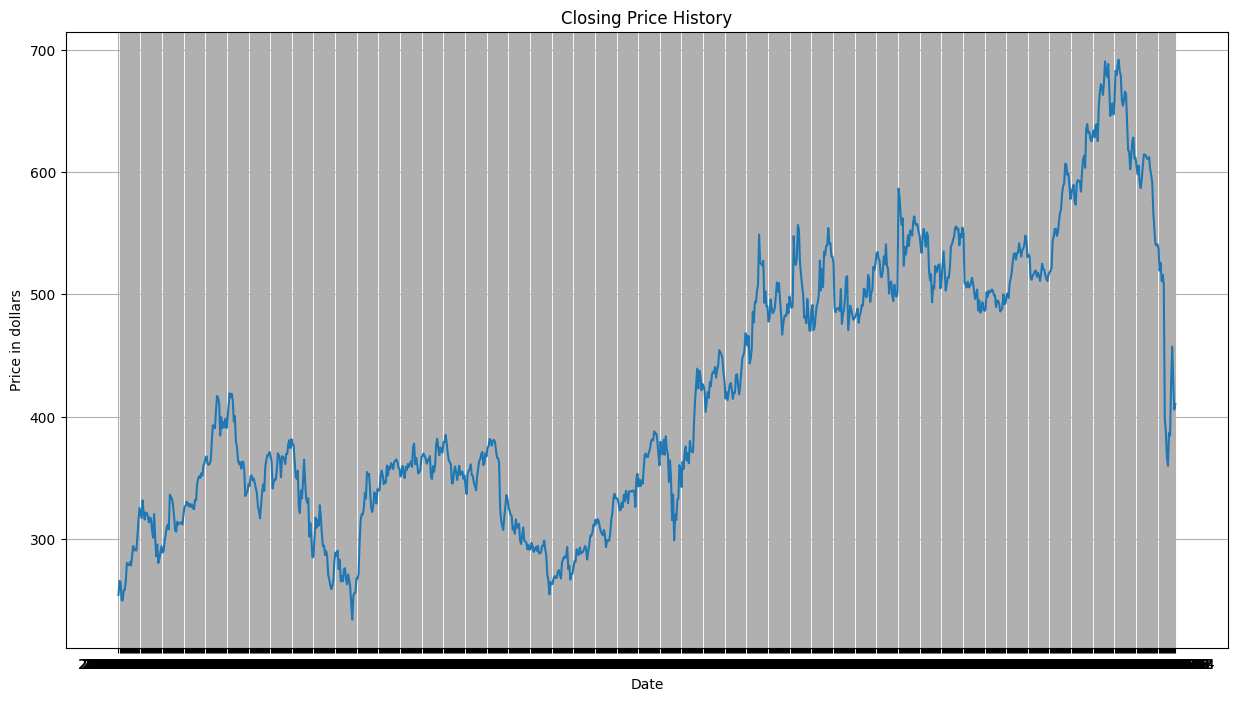

In [12]:
plt.figure(figsize=(15,8))
plt.plot(stock_df['Close'])
plt.title('Closing Price History')
plt.xlabel('Date')
plt.ylabel('Price in dollars')
plt.grid()
plt.show()

Text(0.5, 1.0, 'Box Plots')

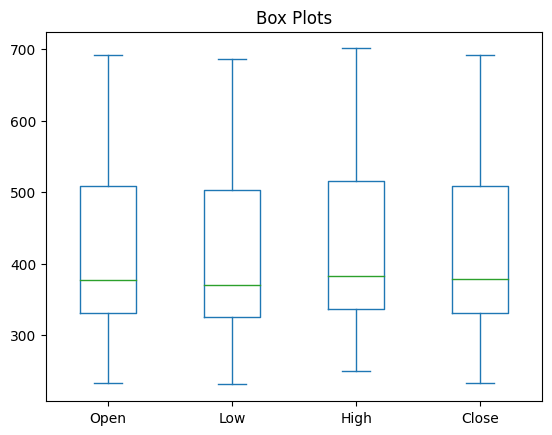

In [40]:
stock_df[['Open','Low','High','Close']].plot(kind='box')
plt.title('Box Plots')

From above we can see that there are no outliers in the required columns

### Model Building

Calculating length of stock_df

In [13]:
len_df = int(stock_df.shape[0])

In [14]:
len_df

1009

80% data is used for training and 20% data is used for testing

In [15]:
stock_train = pd.DataFrame(stock_df['Close'][0:int(len_df*0.8)])            
stock_test = pd.DataFrame(stock_df['Close'][int(len_df*0.8):len_df])   

print(stock_train.shape)
print(stock_test.shape)

(807, 1)
(202, 1)


Scaling the data using MinMaxScaler

In [16]:
scaler = MinMaxScaler(feature_range=(0,1))

In [17]:
stock_train_arr = scaler.fit_transform(stock_train)
stock_train_arr

array([[0.05782213],
       [0.09033648],
       [0.08704531],
       [0.04601941],
       [0.04423196],
       [0.06829145],
       [0.06919929],
       [0.09113089],
       [0.13161772],
       [0.12665262],
       [0.12673773],
       [0.13380242],
       [0.12557455],
       [0.14767629],
       [0.17102649],
       [0.16095437],
       [0.16313907],
       [0.16033027],
       [0.19057476],
       [0.23015375],
       [0.25914995],
       [0.24763092],
       [0.23582815],
       [0.27679734],
       [0.24802808],
       [0.2326505 ],
       [0.24873738],
       [0.24743229],
       [0.23994213],
       [0.22584123],
       [0.23724675],
       [0.23435284],
       [0.20660501],
       [0.1902627 ],
       [0.24533279],
       [0.1895534 ],
       [0.14722233],
       [0.17440276],
       [0.13167452],
       [0.14126427],
       [0.15621629],
       [0.17048741],
       [0.15596095],
       [0.15902509],
       [0.18211995],
       [0.19800829],
       [0.21383984],
       [0.220

In [18]:
stock_train_arr.shape

(807, 1)

In [19]:
X_train = []
y_train = []

for i in range(60,stock_train_arr.shape[0]):
    X_train.append(stock_train_arr[i-60:i])
    y_train.append(stock_train_arr[i,0])
    
X_train,y_train = np.array(X_train),np.array(y_train)

Building LSTM Model

In [20]:
model = Sequential()

model.add(LSTM(units=50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1],1)))
model.add(LSTM(units=50, activation = 'relu', return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


Compiling & fitting the model 

In [22]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
hist = model.fit(X_train,y_train, epochs = 20, batch_size = 32, verbose = 1 )

Epoch 1/20
24/24 [==============================] - 11s 57ms/step - loss: 0.0709
Epoch 2/20
24/24 [==============================] - 1s 55ms/step - loss: 0.0076
Epoch 3/20
24/24 [==============================] - 1s 54ms/step - loss: 0.0035
Epoch 4/20
24/24 [==============================] - 1s 54ms/step - loss: 0.0032
Epoch 5/20
24/24 [==============================] - 1s 55ms/step - loss: 0.0029
Epoch 6/20
24/24 [==============================] - 1s 54ms/step - loss: 0.0028
Epoch 7/20
24/24 [==============================] - 1s 55ms/step - loss: 0.0027
Epoch 8/20
24/24 [==============================] - 2s 72ms/step - loss: 0.0028
Epoch 9/20
24/24 [==============================] - 2s 84ms/step - loss: 0.0027
Epoch 10/20
24/24 [==============================] - 1s 54ms/step - loss: 0.0025
Epoch 11/20
24/24 [==============================] - 1s 55ms/step - loss: 0.0024
Epoch 12/20
24/24 [==============================] - 1s 56ms/step - loss: 0.0023
Epoch 13/20
24/24 [=================

Taking last 100 training data record and adding it to test data for more accurate results

In [23]:
train_tail = stock_train.tail(100)

final_df = train_tail.append(stock_test, ignore_index=True)

input_data = scaler.fit_transform(final_df)
input_data

array([[0.37103526],
       [0.37742098],
       [0.39657814],
       [0.39459021],
       [0.43639862],
       [0.43278411],
       [0.41513293],
       [0.41751255],
       [0.47013471],
       [0.46073667],
       [0.4033254 ],
       [0.42588629],
       [0.43230216],
       [0.49013517],
       [0.48218326],
       [0.49739453],
       [0.52170251],
       [0.52637129],
       [0.50968392],
       [0.50492488],
       [0.46621878],
       [0.46468256],
       [0.48019515],
       [0.51558778],
       [0.49667165],
       [0.54528743],
       [0.49146052],
       [0.48525552],
       [0.42407899],
       [0.44938103],
       [0.45392929],
       [0.41989216],
       [0.40528327],
       [0.44606766],
       [0.42519346],
       [0.41651858],
       [0.42793452],
       [0.68267123],
       [0.66309233],
       [0.61890412],
       [0.59363241],
       [0.60914481],
       [0.49272575],
       [0.53887156],
       [0.52016629],
       [0.54019691],
       [0.5676676 ],
       [0.541

In [24]:
input_data.shape

(302, 1)

In [32]:
# Preparing the testing data
X_test = []
y_test = []

for i in range(60,input_data.shape[0]):
    X_test.append(input_data[i-60:i])
    y_test.append(input_data[i,0])
    
X_test,y_test = np.array(X_test), np.array(y_test)
print(X_test.shape)
print(y_test.shape)

(242, 60, 1)
(242,)


In [33]:
y_pred = model.predict(X_test)
print(y_pred.shape)

8/8 [==============================] - 0s 16ms/step
(242, 1)


In [34]:
scaler.scale_

array([0.00301214])

Multiplying y_pred and y_test with scale_factor to rescale the data for proper comparision

In [35]:
scale_factor = 1/0.00301214
y_pred = y_pred * scale_factor
y_test = y_test * scale_factor

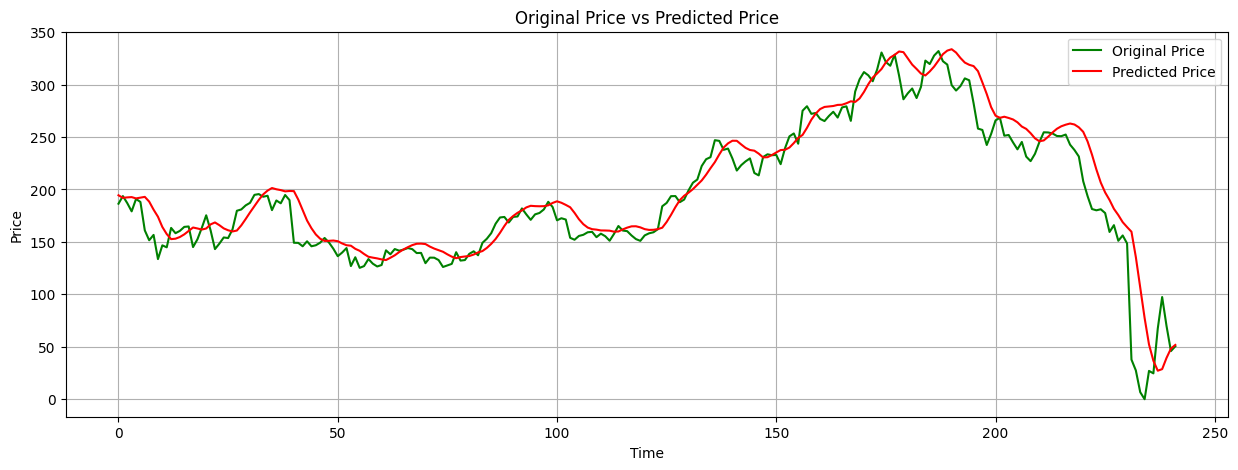

In [38]:
plt.figure(figsize = (15,5))
plt.plot(y_test,'g',label = 'Original Price')
plt.plot(y_pred,'r',label = 'Predicted Price')
plt.title('Original Price vs Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

### Model Evaluation

In [37]:
rmse = np.sqrt(np.mean(y_pred - y_test)**2)
print(f'Root Mean Squared Error : {rmse}')

Root Mean Squared Error : 8.690791393934498
